# COMP 5118 - Trends in Big Data Management
## Project Source Code

The MongoDB database is set up locally and this script allows to connect to it and perform the necessary queries. 

The database consists of the Events from the StatsBomb Open Data [1]. The Events were imported into the database using the `mongoimport` command line tool. The Events are stored in the `eventswithID` collection in the `statsbomb` database. The Events are stored in the database in the same format as they are in the JSON files provided by StatsBomb.

Our collection contains an extra variable called the match_id which is an identifier. This is used to identify the match in which the events takes place. The match_id is not present in the original JSON files provided by StatsBomb. 

The code uses Python 3.9.16 and PyMongo 4.3.3. 
Using MongoDB: 6.0.5
Using Mongosh: 1.8.0

[1] https://github.com/statsbomb/open-data

### Authors
- [Mohammad Bin Yousuf]
- [Tariq El-Bahrawy]
- [Booshra Nazifa Mahmud]

### Library Imports

In [1]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from pymongo import MongoClient
import pandas as pd
import numpy as np
from bson.son import SON
import os
import subprocess
import matplotlib.pyplot as plt
import mplsoccer
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from mplsoccer.pitch import Pitch

### Function Definitions

In [2]:
def plot_on_pitch(sequences, radius_yards):
    
    # create pitch
    pitch = Pitch(pitch_type='statsbomb', pitch_color='grass', line_color='white')

    # get x and y coordinates from input sequence
    x_coords = [point[0] for point in sequences[0]]
    y_coords = [point[1] for point in sequences[0]]

    # create figure and axis objects
    fig, ax = pitch.draw(figsize=(10, 7))

    # plot the points and connect them with red arrows
    for i in range(len(x_coords) - 1):
        ax.annotate("", xytext=(x_coords[i], y_coords[i]), xy=(x_coords[i+1], y_coords[i+1]),
                    arrowprops=dict(arrowstyle='->', linewidth=2, color='red'))

    # add lighter color around the points based on radius input
    ax.scatter(x_coords, y_coords, s=200, alpha=0.5, color='#f2c75c')
    circle = plt.Circle((x_coords[0], y_coords[0]), radius_yards, color='#f2c75c', alpha=0.2)
    ax.add_artist(circle)

    plt.show()
    
def visualize_sequences(sorted_sequences, num):
    fig, axs = plt.subplots(nrows=num, figsize=(10, 4*num))
    for i, sequence in enumerate(sorted_sequences[:num]):
        ax = axs[i]
        pitch = mplsoccer.Pitch(pitch_type='statsbomb', pitch_color='grass', line_color='white', linewidth=2, stripe=True)
        pitch.draw(ax=ax)
        x, y = zip(*sequence)
        if i == 0:
            ax.scatter(x, y, color='red', zorder=2)
            ax.set_title(f"Reference Sequence")
        else:
            ax.scatter(x, y, color='blue', zorder=2)
            ax.set_title(f"Sequence {i}")
        for j in range(len(sequence)-1):
            if i == 0:
                ax.annotate("", xytext=sequence[j], xy=sequence[j+1], arrowprops=dict(arrowstyle="->", color='red', lw=2), zorder=1)
            else:
                ax.annotate("", xytext=sequence[j], xy=sequence[j+1], arrowprops=dict(arrowstyle="->", color='blue', lw=2), zorder=1)
    plt.show()

### MongoDB Connection

In [3]:
# Designate client
client = MongoClient('localhost', 27017)

# Designate database
db = client.statsbomb

# Designate collection
collection = db.eventswithid

### User Input 

In [4]:
# Input sequence and radius

radius_yards = 5

search_next = 4

# This will be a user input sequence
# sequences = [[[6.0, 30.0], [20.0, 18.0], [60.0, 10.0], [85.0, 20.0], [108.0, 40.0]]]                                # Alternative test sequence - 5 points - Test points in the Report
sequences = [[[60.0, 32.0], [60.0, 10.0], [70.0, 35.0], [85.0, 20.0], [108.0, 40.0]]]                             # Alternative test sequence - 5 points
# sequences = [[[60.0, 32.0], [60.0, 10.0], [70.0, 35.0], [85.0, 20.0], [100.0, 10.0], [108.0, 40.0]]]                # Alternative test sequence - 6 points
# sequences = [[[60.0, 32.0], [60.0, 10.0], [70.0, 35.0], [85.0, 20.0], [100.0, 10.0], [108.0, 40.0], [120.0, 20.0]]] # Alternative test sequence - 7 points
sequences

[[[60.0, 32.0], [60.0, 10.0], [70.0, 35.0], [85.0, 20.0], [108.0, 40.0]]]

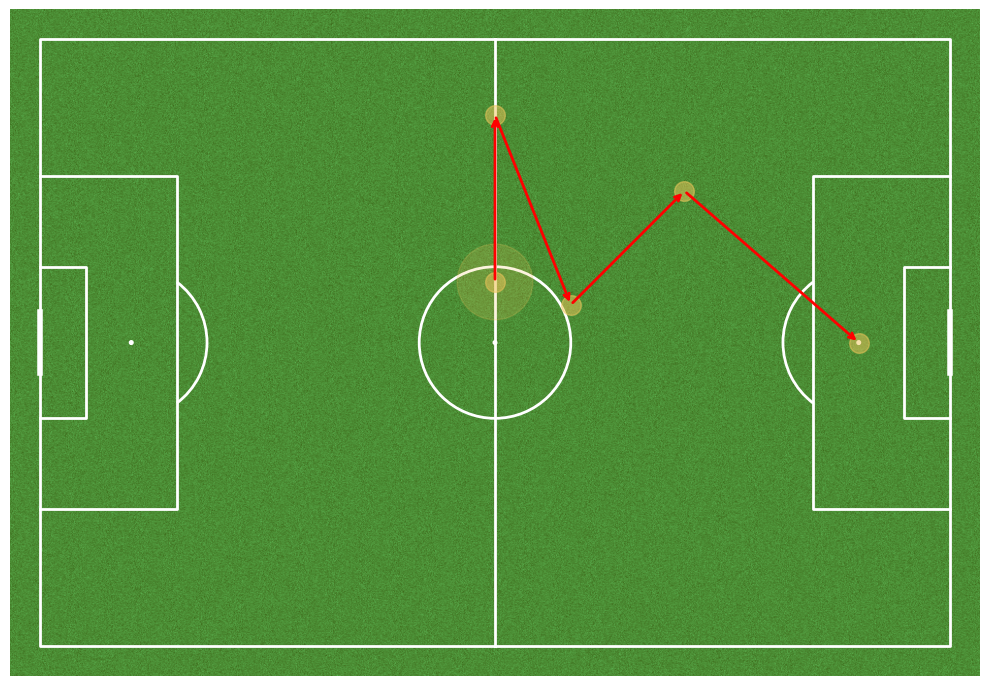

In [5]:
plot_on_pitch(sequences, radius_yards)

### Search

In [6]:
# Query the database for all events within the specified radius

query = {
        "location": {
            "$geoWithin": {
                "$center": [[sequences[0][0][0], sequences[0][0][1]], radius_yards] # specify center coordinates and radius
            }
        }
    }

cursor = collection.find(query)

In [7]:
# Perform the Search

for count, doc in enumerate(cursor):
    sequence = []
    if count == 0: # if the current document is the first one in the query result
        reference_sequence = [] # store the first sequence as the reference
        if "location" in doc: # check if the document has a "location" field
            reference_sequence.append(doc["location"])
            next_query = {
                "match_id": doc["match_id"],
                "index": {"$gt": doc["index"]}
            }
            next_cursor = collection.find(next_query).sort("index").limit(search_next)
            for next_doc in next_cursor:
                if "location" in next_doc: # check if the document has a "location" field
                    coordinates = next_doc["location"]
                    reference_sequence.append(coordinates)
            sequences.append(reference_sequence) # append the reference sequence to the sequences list
    else: # for all other documents, calculate the distance to the reference sequence
        if "location" in doc: # check if the document has a "location" field
            coordinates = doc["location"]
            sequence.append(coordinates)
            next_query = {
                "match_id": doc["match_id"],
                "index": {"$gt": doc["index"]}
            }
            next_cursor = collection.find(next_query).sort("index").limit(search_next)
            for next_doc in next_cursor:
                if "location" in next_doc: # check if the document has a "location" field
                    coordinates = next_doc["location"]
                    sequence.append(coordinates)
            distance, path = fastdtw(reference_sequence, sequence, dist=euclidean)
            print(f"Reference Sequence vs Sequence {count+1} ({sequence[0][0]}, {sequence[0][1]}) distance: {distance:.2f}")
            sequences.append(sequence) # append the current sequence to the sequences list

Reference Sequence vs Sequence 2 (64.3, 30.5) distance: 47.90
Reference Sequence vs Sequence 3 (59.9, 34.9) distance: 40.83
Reference Sequence vs Sequence 4 (59.3, 35.5) distance: 42.38
Reference Sequence vs Sequence 5 (58.6, 28.3) distance: 157.51
Reference Sequence vs Sequence 6 (62.0, 34.9) distance: 130.62
Reference Sequence vs Sequence 7 (62.4, 30.1) distance: 56.98
Reference Sequence vs Sequence 8 (62.4, 30.1) distance: 59.91
Reference Sequence vs Sequence 9 (63.6, 28.9) distance: 61.63
Reference Sequence vs Sequence 10 (63.7, 33.9) distance: 67.51
Reference Sequence vs Sequence 11 (59.9, 35.9) distance: 95.35
Reference Sequence vs Sequence 12 (64.4, 33.1) distance: 87.97
Reference Sequence vs Sequence 13 (64.4, 33.1) distance: 72.38
Reference Sequence vs Sequence 14 (62.1, 28.4) distance: 94.33
Reference Sequence vs Sequence 15 (62.1, 28.4) distance: 115.91
Reference Sequence vs Sequence 16 (57.2, 31.2) distance: 41.35
Reference Sequence vs Sequence 17 (57.2, 31.2) distance: 54.

### Distance Calculation

In [8]:
# Calculate distances between reference sequence and all other sequences
ref_sequence = sequences[0]
distances = [fastdtw(ref_sequence, seq, dist=euclidean)[0] for seq in sequences[1:]]

### Sorting Distances

In [9]:
# Combine distances with sequences using zip
zipped = zip(distances, sequences[1:])

sorted_sequences = []

# Sort by distance and add reference sequence to the front of the list
sorted_zipped = sorted(zipped, key=lambda x: x[0])
sorted_sequences = [ref_sequence] + [seq for _, seq in sorted_zipped]

### Displaying Matched Sequences

In [10]:
# User Input - Number of sequences to visualize 
num = 5

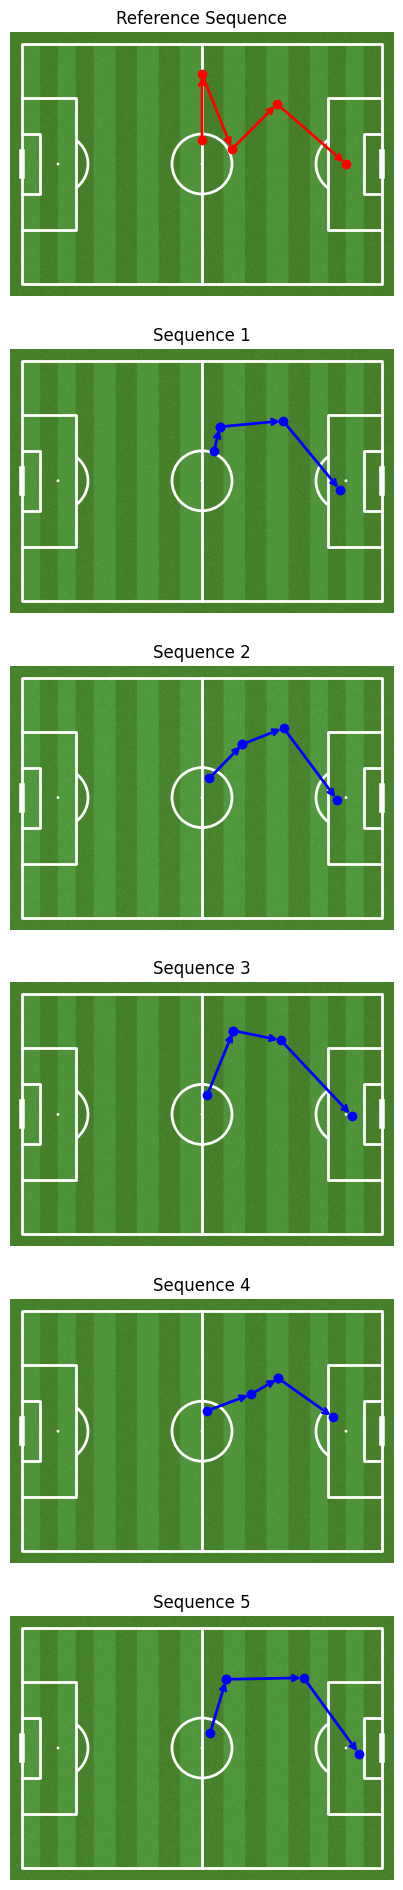

In [11]:
visualize_sequences(sorted_sequences, num+1)